In [1]:
import blackhc.project.script

Appended /home/blackhc/PycharmProjects/unifying_dss_exp/src to paths
Switched to directory /home/blackhc/PycharmProjects/unifying_dss_exp
%load_ext autoreload
%autoreload 2


In [2]:
from models import *

In [3]:
import torch

In [4]:
from datasets.factories import get_dataset

In [5]:
from dataset_operations import RandomSubsetDataset

In [6]:
split_dataset = get_dataset(
    "MNIST", normalize_like_cifar10=False, root="data/", validation_set_size=1000, device_hint="cuda"
)

In [52]:
model_trainer = MnistModelTrainer("cuda", max_training_epochs=200, num_evaluation_batch_size=512)

In [8]:
train_loader = model_trainer.get_train_dataloader(split_dataset.train)
test_loader = model_trainer.get_evaluation_dataloader(split_dataset.test)
validation_loader = model_trainer.get_evaluation_dataloader(split_dataset.validation)

In [9]:
import black_box_model_training

In [10]:
model_info = torch.load("./bnn_mnist_cnn_model.pt")

In [11]:
from trained_model import TrainedBayesianModel
from consistent_mc_dropout import DeterministicModel

In [12]:
def get_model_instance():
    model = BayesianMNISTCNN()
    model.load_state_dict(model_info["model"])
    return DeterministicModel(model)

model = get_model_instance()

In [13]:
test_metrics = black_box_model_training.evaluate_simple(model=model, loader=test_loader, device="cuda")
test_metrics

[1/79]   1%|1          [00:00<?]

{'accuracy': 0.8392, 'crossentropy': 1.0301890625}

In [14]:
model_info["test_metrics"]

{'accuracy': 0.8384, 'crossentropy': tensor(0.5493)}

In [15]:
from active_learning import ActiveLearningData

In [16]:
active_learning_data = ActiveLearningData(split_dataset.train)

In [17]:
active_learning_data.acquire_base_indices(model_info["train_indices"])

In [18]:
eval_dataset = active_learning_data.extract_dataset_from_pool(20000)

In [19]:
len(eval_dataset)

20000

In [20]:
len(active_learning_data.pool_dataset)

38920

In [21]:
pool_sample_dataset = active_learning_data.extract_dataset_from_pool(1000)

In [22]:
train_loader = model_trainer.get_evaluation_dataloader(active_learning_data.training_dataset)
# pool_loader = model_trainer.get_evaluation_dataloader(active_learning_data.pool_dataset)
eval_loader = model_trainer.get_evaluation_dataloader(eval_dataset)

In [23]:
black_box_model_training.evaluate_simple(model=model, loader=train_loader, device="cuda")

{'accuracy': 1.0, 'crossentropy': 1.7165648387162946e-06}

In [24]:
import laplace
import numpy as np

In [25]:
def C_k(la):
    return la.n_params / 2 * (np.log(2 * np.pi) + 1)


def get_model_param_entropy(
    train_loader, prior_precision=None, subset_of_weights="last_layer", hessian_structure="full", use_ggn=True
):
    model = get_model_instance()
    la = laplace.Laplace(
        model,
        "classification",
        prior_precision=prior_precision or 1.0,
        subset_of_weights=subset_of_weights,
        hessian_structure=hessian_structure,
        backend=laplace.curvature.AsdlGGN if use_ggn else laplace.curvature.AsdlEF,
    )
    la.fit(train_loader)
    if prior_precision is None:
        la.optimize_prior_precision(method="marglik")

    return la.log_det_posterior_precision / -2 + C_k(la)

In [26]:
get_model_param_entropy(train_loader, prior_precision=None, use_ggn=False)

tensor(4226.7900)

In [27]:
from torch.utils.data import ConcatDataset, TensorDataset

In [28]:
from tqdm.auto import tqdm

In [29]:
import dataclasses
from dataclasses import dataclass

In [30]:
@dataclass
class ApproxSettings:
    subset_of_weights: str = "last_layer"
    hessian_structure: str = "full"
    use_ggn: bool = True

    def to_kwargs(self):
        kwargs = dict(
            subset_of_weights=self.subset_of_weights,
            hessian_structure=self.hessian_structure,
            backend=laplace.curvature.AsdlGGN if self.use_ggn else laplace.curvature.AsdlEF,
        )
        return kwargs

In [31]:
@dataclass
class WeightSpaceQuantities:
    xig_approx_log_det: float
    xig_approx_trace: float
    xig_proxy: float

    xpig_proxy_log_det: float
    xpig_proxy_trace: float

    jxpig_proxy_log_det: float
    jxpig_proxy_trace: float

In [32]:
def compute_weight_space_quantities(
    pool_dataset,
    train_loader,
    eval_loader,
    prior_precision=1.0,
    acq_settings: ApproxSettings = ApproxSettings(),
    eval_settings: ApproxSettings = ApproxSettings(),
    prior_settings: ApproxSettings = ApproxSettings(),
):
    prior_model = get_model_instance()
    prior_la = laplace.Laplace(
        prior_model, "classification", prior_precision=prior_precision or 0.0, **prior_settings.to_kwargs()
    )
    prior_la.fit(train_loader)
    prior_la.H = prior_la.H.to(torch.float64)
    if prior_precision is None:
        prior_la.optimize_prior_precision(method="marglik")

    prior_posterior_precision = prior_la.posterior_precision
    prior_inv_posterior_precision = prior_la.posterior_covariance

    eval_model = get_model_instance()
    eval_la = laplace.Laplace(eval_model, "classification", prior_precision=0, **eval_settings.to_kwargs())
    eval_la.fit(eval_loader)
    eval_la.H = eval_la.H.to(torch.float64)

    acq_model = get_model_instance()
    acq_la = laplace.Laplace(acq_model, "classification", prior_precision=0, **acq_settings.to_kwargs())

    pool_weight_space_quantities = []
    for X, y in tqdm(pool_dataset):
        i_dataset = TensorDataset(X[None, ...], y[None, ...])
        i_dataloader = model_trainer.get_evaluation_dataloader(i_dataset)
        acq_la.fit(i_dataloader, override=True)
        acq_la.H = acq_la.H.to(torch.float64)

        xig_objective = acq_la.posterior_precision @ prior_inv_posterior_precision
        xig_approx_log_det = 0.5 * (xig_objective + torch.eye(len(xig_objective))).logdet()
        xig_approx_trace = 0.5 * torch.trace(xig_objective)
        xig_proxy = 0.5 * (acq_la.posterior_precision + prior_posterior_precision).logdet() - C_k(acq_la)

        inv_acq_plus_prior = laplace.utils.invsqrt_precision(acq_la.posterior_precision + prior_posterior_precision)
        inv_acq_plus_prior = inv_acq_plus_prior @ inv_acq_plus_prior.T

        jxpig_objective = eval_la.posterior_precision @ inv_acq_plus_prior
        # jxpig_proxy_log_det = (jxpig_objective.to(torch.float64) + torch.eye(len(jxpig_objective), dtype=torch.float64)).logdet()
        jxpig_proxy_log_det = (jxpig_objective + torch.eye(len(jxpig_objective))).logdet()
        jxpig_proxy_trace = torch.trace(jxpig_objective)

        xpig_objective = jxpig_objective / eval_la.n_data
        xpig_proxy_log_det = (xpig_objective + torch.eye(len(xpig_objective))).logdet()
        xpig_proxy_trace = torch.trace(xpig_objective)

        pool_weight_space_quantities.append(
            WeightSpaceQuantities(
                xig_approx_log_det=float(xig_approx_log_det),
                xig_approx_trace=float(xig_approx_trace),
                xig_proxy=float(xig_proxy),
                xpig_proxy_log_det=float(xpig_proxy_log_det),
                xpig_proxy_trace=float(xpig_proxy_trace),
                jxpig_proxy_log_det=float(jxpig_proxy_log_det),
                jxpig_proxy_trace=float(jxpig_proxy_trace),
            )
        )

    return pool_weight_space_quantities

In [131]:
# pool_weight_space_quantities = compute_weight_space_quantities(
#     pool_sample_dataset, train_loader=train_loader, eval_loader=eval_loader, prior_precision=None, prior_settings=ApproxSettings(use_ggn=True)
# )
# torch.save(pool_weight_space_quantities, "mnist_weight_space_quantities_1k_train.pt")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
pool_weight_space_quantities=torch.load("mnist_weight_space_quantities_1k_train.pt")

In [49]:
# def compute_prediction_space_quantities(model, train_loader, prior_precision, loader, settings: ApproxSettings = ApproxSettings(),):
# TODO(blackhc): There is a bug in here somewhere. The normal BNN via MC dropout works well enough though.

def get_model_la(
    model,
    train_loader,
    prior_precision,
    settings: ApproxSettings = ApproxSettings(),
):
    model = get_model_instance()
    la = laplace.Laplace(model, "classification", prior_precision=prior_precision or 0.0, **settings.to_kwargs())
    la.fit(train_loader)
    if prior_precision is None:
        la.optimize_prior_precision(method="marglik")
    return la


def compute_joint_predictions_last_layer_functional(la, loader, n_samples=100):
    fs = []
    
    for sample in tqdm(la.sample(n_samples)):
        direction = sample - la.mean
        fs_row = []
        for X_batch, y in tqdm(loader):
            Js, f_mu = la.backend.last_layer_jacobians(X_batch.to(la._device))
            #print(Js.shape, f_mu.shape, direction.shape)
            predictions = f_mu + Js @ direction
            #print(predictions.shape)
            fs_row.append(predictions.detach())
        fs.append(torch.concat(fs_row))
    fs = torch.stack(fs)
    if la.likelihood == "classification":
        fs = torch.softmax(fs, dim=-1)
    return fs
                  
def compute_joint_predictions_last_layer(la, loader, n_samples=100):
    fs = list()
    for sample in tqdm(la.sample(n_samples)):
        torch.nn.utils.vector_to_parameters(sample, la.model.last_layer.parameters())
        fs_row = []
        for X_batch, y in tqdm(loader):
            fs_row.append(la.model(X_batch.to(la._device)).detach())
        fs.append(torch.concat(fs_row))
    torch.nn.utils.vector_to_parameters(la.mean, la.model.last_layer.parameters())
    fs = torch.stack(fs)
    if la.likelihood == "classification":
        fs = torch.softmax(fs, dim=-1)
    return fs

In [38]:
eval_pool_dataset = ConcatDataset([eval_dataset, pool_sample_dataset])
len(eval_pool_dataset), len(eval_dataset), len(pool_sample_dataset)

(21000, 20000, 1000)

In [53]:
eval_pool_loader = model_trainer.get_evaluation_dataloader(eval_pool_dataset)

In [64]:
# trained_model = TrainedBayesianModel(get_model_instance().bayesian_module)
# eval_pool_probs_K_N_C = trained_model.get_log_probs_N_K_C(eval_pool_loader, num_samples=100, device="cuda", storage_device="cpu").permute((1,0,2)).exp()

# torch.save(eval_pool_probs_K_N_C, "bnn_eval_pool_probs_K_N_C.pt")

get_predictions_labels:   0%|          | 0/2100000 [00:00<?, ?it/s]

In [86]:
eval_pool_probs_K_N_C = torch.load("bnn_eval_pool_probs_K_N_C.pt")

In [36]:
# la = get_model_la(get_model_instance(), train_loader, None)

In [220]:
# eval_pool_probs_K_N_C = compute_joint_predictions_last_layer(la, eval_pool_loader, n_samples=20)
# torch.save(eval_pool_probs_K_N_C, "bnn_eval_pool_probs_K_N_C_nn_la_samples.pt")

In [54]:
# eval_pool_probs_K_N_C = compute_joint_predictions_last_layer_functional(la, eval_pool_loader, n_samples=20)
# torch.save(eval_pool_probs_K_N_C, "bnn_eval_pool_probs_K_N_C_functional.pt")

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [55]:
import torch.jit
from toma import toma
from toma import cpu_memory

In [56]:
cpu_memory.set_cpu_memory_limit(20)

In [57]:
@torch.jit.script
def compute_entropy(probs_C):
    nats = -probs_C * probs_C.log()
    nats = torch.where(nats.isnan(), 0.0, nats)
    entropy = nats.sum(dim=-1)
    return entropy


@torch.jit.script
def compute_bald(probs_K_N_C):
    entropy_K_N = compute_entropy(probs_K_N_C)
    entropy_N = entropy_K_N.mean(dim=0)
    avg_probs_N_C = probs_K_N_C.mean(dim=0)
    avg_entropy_N = compute_entropy(avg_probs_N_C)
    score = avg_entropy_N - entropy_N
    return score


def compute_epig(eval_probs_K_M_C, acq_probs_K_N_C):
    # I[Y_e; Y_a |X_e, x_a] = H[Y_e | X_e] + H[Y_a | x_a] - H[Y_e, Y_a | X_e, x_a]
    H_eval = compute_entropy(eval_probs_K_M_C.mean(dim=0)).mean(dim=0)
    H_acq_N = compute_entropy(acq_probs_K_N_C.mean(dim=0))

    # Compute joint entropy
    K = eval_probs_K_M_C.shape[0]
    M = eval_probs_K_M_C.shape[1]
    N = acq_probs_K_N_C.shape[1]
    C = acq_probs_K_N_C.shape[2]

    H_eval_acq_N = 0
    
    @toma.execute.batch(1024)
    def loop(batchsize: int):
        nonlocal H_eval_acq_N
        H_eval_acq_N = 0
        for eval_probs_K_m_C in tqdm(eval_probs_K_M_C.split(batchsize, dim=1)):
            eval_probs_K_mC = eval_probs_K_m_C.reshape(K, eval_probs_K_m_C.shape[1] * C)
            acq_probs_N_C_K = acq_probs_K_N_C.permute((1, 2, 0))
            probs_N_C_mC = acq_probs_N_C_K @ eval_probs_K_mC / K
            # print(probs_K_N_C_M_C.shape)
            nats_N_C_mC = -probs_N_C_mC * probs_N_C_mC.log()
            nats_N_C_mC = torch.where(nats_N_C_mC.isnan(), 0.0, nats_N_C_mC)
            H_eval_acq_N += nats_N_C_mC.sum(dim=(1, 2))
        
        H_eval_acq_N /= M

    epig_score_N = H_eval + H_acq_N - H_eval_acq_N
    return epig_score_N

In [118]:
eval_pool_probs_K_N_C.shape

torch.Size([100, 21000, 10])

In [119]:
bald_score = compute_bald(eval_pool_probs_K_N_C[:, len(eval_dataset) :])

In [120]:
bald_score.min(),bald_score.max()

(tensor(1.7091e-05), tensor(1.1445))

In [121]:
epig_score = compute_epig(
    eval_pool_probs_K_N_C[:, : len(eval_dataset)].to(torch.float64),
    eval_pool_probs_K_N_C[:, len(eval_dataset) :].to(torch.float64),
)

  0%|          | 0/20 [00:00<?, ?it/s]

In [122]:
epig_score


tensor([2.4132e-03, 3.1680e-03, 1.5370e-02, 5.6336e-03, 4.6324e-03, 6.8235e-03,
        1.7525e-03, 5.0076e-03, 2.2676e-03, 9.8253e-03, 1.0877e-02, 1.0741e-02,
        5.6237e-03, 1.6592e-02, 1.1088e-03, 5.5080e-04, 8.3453e-03, 6.5942e-03,
        1.0002e-02, 7.2635e-06, 2.8603e-04, 1.6602e-04, 8.0445e-03, 3.3938e-04,
        1.2998e-02, 8.3858e-04, 4.0461e-03, 6.6663e-03, 1.6802e-05, 4.1531e-04,
        1.2717e-02, 1.9027e-04, 1.6332e-04, 9.0790e-03, 1.3036e-02, 1.0440e-02,
        5.0492e-03, 3.3443e-03, 2.2953e-02, 9.3571e-03, 1.3172e-03, 7.7178e-03,
        1.0588e-04, 1.1782e-04, 2.6948e-04, 2.4263e-02, 6.2775e-03, 1.7316e-03,
        1.1973e-02, 1.5957e-03, 7.0551e-04, 3.5105e-03, 8.2786e-04, 2.0773e-02,
        9.8144e-04, 1.3584e-02, 1.3553e-02, 1.5693e-03, 1.2084e-02, 1.5980e-02,
        6.2482e-03, 1.9262e-03, 9.0287e-03, 7.7821e-03, 8.6221e-03, 1.1125e-02,
        1.9706e-02, 1.1132e-02, 2.3457e-02, 1.3610e-04, 1.7529e-02, 1.3733e-02,
        2.2265e-03, 1.4031e-02, 1.9286e-

In [123]:
import matplotlib.pyplot as plt

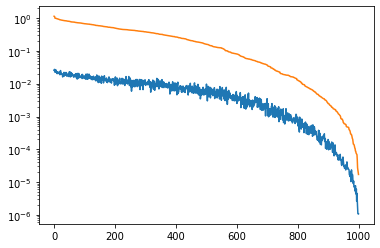

In [124]:
sorted_indices = bald_score.argsort(descending=True)
plt.plot(epig_score[sorted_indices].numpy())
plt.plot(bald_score[sorted_indices].numpy())
plt.yscale("log")

In [93]:
!pip install seaborn[stats]

In [94]:
import seaborn as sns

In [95]:
import pandas as pd

In [96]:
df_quantities = pd.DataFrame.from_dict(pool_weight_space_quantities)
df_quantities


,xig_approx_log_det,xig_approx_trace,xig_proxy,xpig_proxy_log_det,xpig_proxy_trace,jxpig_proxy_log_det,jxpig_proxy_trace
0,0.073518,0.079160,-2630.816885,123.247716,531.319025,5585.296566,1.062638e+07
1,0.041483,0.042563,-2630.848919,123.307826,534.369649,5585.360472,1.068739e+07
2,4.672380,1082.447666,-2626.218023,120.141406,484.193765,5576.253764,9.683875e+06
3,0.038386,0.039558,-2630.852017,123.330052,536.557832,5585.366829,1.073116e+07
4,0.004179,0.004194,-2630.886224,123.372711,537.249969,5585.435106,1.074500e+07
...,...,...,...,...,...,...,...
995,0.416036,0.648732,-2630.474367,122.675584,513.312366,5584.611673,1.026625e+07
996,0.000049,0.000049,-2630.890354,123.379587,537.484056,5585.443377,1.074968e+07
997,0.007150,0.007201,-2630.883253,123.367602,536.901617,5585.429184,1.073803e+07
998,0.033534,0.034610,-2630.856869,123.323768,534.839015,5585.376397,1.069678e+07


In [97]:
df_quantities["bald"]=bald_score

In [98]:
df_quantities["epig"]=epig_score

In [125]:
normalized_df = df_quantities.rank()
df_quantities["average_normalized_score"] = (normalized_df["bald"] + normalized_df["epig"]) + (normalized_df["xig_approx_log_det"]+normalized_df["xig_approx_trace"]+normalized_df["xig_proxy"])/3 - (normalized_df["xpig_proxy_log_det"]+normalized_df["xpig_proxy_trace"]+normalized_df["jxpig_proxy_log_det"]+normalized_df["jxpig_proxy_trace"])/4
df_quantities["average_ig_score"] = normalized_df["bald"] + (normalized_df["xig_approx_log_det"]+normalized_df["xig_approx_trace"])/2
df_quantities["average_pig_score"] = normalized_df["epig"] - (normalized_df["xpig_proxy_log_det"]+normalized_df["xpig_proxy_trace"]+normalized_df["jxpig_proxy_log_det"])/3
normalized_df

,xig_approx_log_det,xig_approx_trace,xig_proxy,xpig_proxy_log_det,xpig_proxy_trace,jxpig_proxy_log_det,jxpig_proxy_trace,bald,epig,average_normalized_score,average_ig_score,average_pig_score
0,408.0,408.0,408.0,589.0,569.0,593.0,569.0,304.0,335.0,370.0,364.0,377.0
1,376.0,376.0,376.0,623.0,610.0,625.0,610.0,349.0,381.0,378.0,370.0,385.5
2,849.0,907.0,849.0,198.0,230.0,152.0,230.0,868.0,871.0,862.0,875.0,851.0
3,372.0,372.0,372.0,639.0,670.0,629.0,670.0,507.0,504.0,438.0,445.0,431.0
4,273.0,273.0,273.0,728.0,736.0,729.0,736.0,411.0,450.0,356.0,346.5,367.5
...,...,...,...,...,...,...,...,...,...,...,...,...
995,502.0,505.0,502.0,496.0,463.0,499.0,463.0,594.0,739.0,574.0,547.5,620.0
996,131.0,131.0,131.0,872.0,872.0,870.0,872.0,194.0,236.0,159.0,151.0,167.0
997,297.0,297.0,297.0,700.0,690.0,704.0,690.0,330.0,351.0,326.0,315.0,329.0
998,365.0,365.0,365.0,633.0,619.0,636.0,619.0,200.0,183.0,285.0,286.5,280.0


In [126]:
df_quantities.to_pickle("computed_quantities_mnist_80.pickle")

In [103]:
df_quantities_sorted = df_quantities.sort_values(by=["bald"], ascending=False)
df_quantities_sorted = df_quantities_sorted.reset_index(drop=True)
df_quantities_sorted = df_quantities_sorted.reset_index()
df_quantities_sorted = df_quantities_sorted.rename(columns=dict(index="bald_index"))

df_quantities_sorted = df_quantities_sorted.sort_values(by=["epig"], ascending=False)
df_quantities_sorted = df_quantities_sorted.reset_index(drop=True)
df_quantities_sorted = df_quantities_sorted.reset_index()
df_quantities_sorted = df_quantities_sorted.rename(columns=dict(index="epig_index"))

df_quantities_sorted = df_quantities_sorted.sort_values(by=["average_normalized_score"], ascending=False)
df_quantities_sorted = df_quantities_sorted.reset_index(drop=True)
df_quantities_sorted = df_quantities_sorted.reset_index()
df_quantities_sorted = df_quantities_sorted.rename(columns=dict(index="avg_index"))

df_quantities_sorted = df_quantities_sorted.sort_values(by=["average_ig_score"], ascending=False)
df_quantities_sorted = df_quantities_sorted.reset_index(drop=True)
df_quantities_sorted = df_quantities_sorted.reset_index()
df_quantities_sorted = df_quantities_sorted.rename(columns=dict(index="avg_ig_index"))

df_quantities_sorted = df_quantities_sorted.sort_values(by=["average_pig_score"], ascending=False)
df_quantities_sorted = df_quantities_sorted.reset_index(drop=True)
df_quantities_sorted = df_quantities_sorted.reset_index()
df_quantities_sorted = df_quantities_sorted.rename(columns=dict(index="avg_pig_index"))

In [104]:
df_melted = df_quantities_sorted.melt(id_vars=["bald_index", "epig_index", "avg_index", "avg_ig_index", "avg_pig_index"])
df_melted

,bald_index,epig_index,avg_index,avg_ig_index,avg_pig_index,variable,value
0,4,5,3,27,0,xig_approx_log_det,13.400811
1,9,8,0,7,1,xig_approx_log_det,14.970577
2,2,6,1,6,2,xig_approx_log_det,12.466885
3,17,16,6,16,3,xig_approx_log_det,12.727153
4,1,0,8,28,4,xig_approx_log_det,10.569885
...,...,...,...,...,...,...,...
11995,990,993,995,994,995,average_pig_score,-986.250000
11996,995,995,996,996,996,average_pig_score,-988.000000
11997,997,998,997,997,997,average_pig_score,-993.500000
11998,996,996,998,998,998,average_pig_score,-994.000000


In [105]:
df_melted.variable.unique()

array(['xig_approx_log_det', 'xig_approx_trace', 'xig_proxy',
       'xpig_proxy_log_det', 'xpig_proxy_trace', 'jxpig_proxy_log_det',
       'jxpig_proxy_trace', 'bald', 'epig', 'average_normalized_score',
       'average_ig_score', 'average_pig_score'], dtype=object)

In [106]:
readable_name_map = {'xig_approx_log_det': "(E)IG (LogDet)", 'xig_approx_trace': "(E)IG (Trace)", 'xig_proxy': "(E)IG (Proxy Log Det)",
       'xpig_proxy_log_det': "(E)PIG (LogDet)", 'xpig_proxy_trace': "(E)PIG (Trace)", 'jxpig_proxy_log_det': "J(E)PIG (LogDet)",
       'jxpig_proxy_trace': "J(E)PIG (Trace)", 'bald': "BALD (Prediction Space)", 'epig': "EPIG (Prediction Space)"}

df_melted["Acquisition Function"] = df_melted["variable"].map(readable_name_map)
df_melted

,bald_index,epig_index,avg_index,avg_ig_index,avg_pig_index,variable,value,Acquisition Function
0,4,5,3,27,0,xig_approx_log_det,13.400811,(E)IG (LogDet)
1,9,8,0,7,1,xig_approx_log_det,14.970577,(E)IG (LogDet)
2,2,6,1,6,2,xig_approx_log_det,12.466885,(E)IG (LogDet)
3,17,16,6,16,3,xig_approx_log_det,12.727153,(E)IG (LogDet)
4,1,0,8,28,4,xig_approx_log_det,10.569885,(E)IG (LogDet)
...,...,...,...,...,...,...,...,...
11995,990,993,995,994,995,average_pig_score,-986.250000,NaN
11996,995,995,996,996,996,average_pig_score,-988.000000,NaN
11997,997,998,997,997,997,average_pig_score,-993.500000,NaN
11998,996,996,998,998,998,average_pig_score,-994.000000,NaN


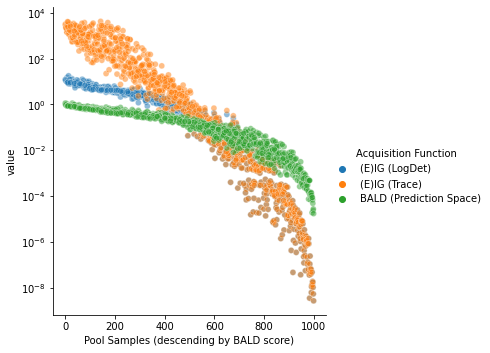

In [107]:
sub_df = df_melted[df_melted.variable.isin(["xig_approx_log_det", "xig_approx_trace", "bald"])]
sub_df = sub_df.copy()
xlabel = "Pool Samples (descending by BALD score)"
sub_df[xlabel] = sub_df["avg_ig_index"]
g=sns.relplot(data=sub_df, x=xlabel, y="value", hue="Acquisition Function", alpha=0.5)
g.ax.set_yscale("log")

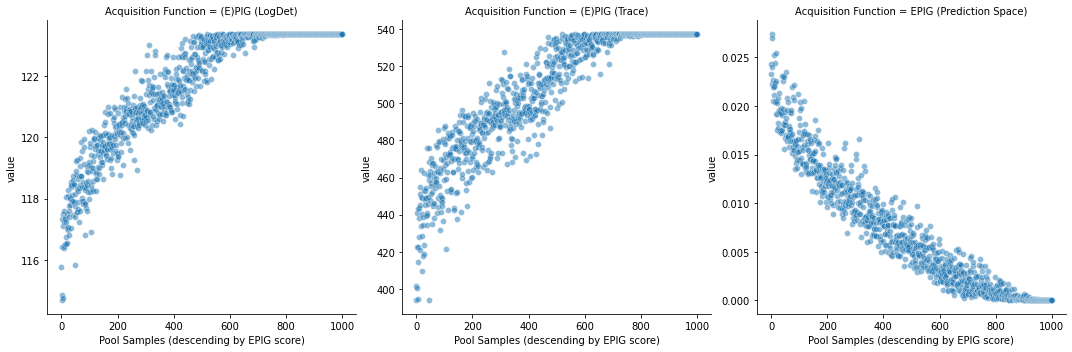

In [108]:
sub_df = df_melted[df_melted.variable.isin(["xpig_proxy_log_det", "xpig_proxy_trace", "epig"])]
sub_df = sub_df.copy()
xlabel = "Pool Samples (descending by EPIG score)"
sub_df[xlabel] = sub_df["avg_pig_index"]
sns.relplot(data=sub_df, x=xlabel, y="value", col="Acquisition Function", alpha=0.5, facet_kws=dict(sharey=False))
#g.ax.set_yscale("log")

In [110]:
def topk_spearman_rank(k):
    def func(s1, s2):
        df = pd.DataFrame.from_dict(dict(s1=s1,s2=s2))
        df_rank=df.rank()
        df_rank_topk = df_rank[(df_rank.s1<=k) | (df_rank.s2<=k)]
        print(len(df_rank_topk))
        corr=df_rank_topk.corr(method="spearman")["s1"]["s2"]
        return corr
    return func

df = df_quantities.copy()
df["xpig_proxy_log_det"] *= -1
df["xpig_proxy_trace"] *= -1
df["jxpig_proxy_log_det"] *= -1
df["jxpig_proxy_trace"] *= -1
df.corr(method=topk_spearman_rank(500))

502
500
502
511
500
511
528
550
517
513
524
502
502
511
502
511
530
552
519
515
526
502
511
500
511
528
550
517
513
524
509
502
509
528
550
517
514
524
511
500
531
550
518
517
525
511
528
550
517
513
524
531
550
518
517
525
529
514
514
515
534
539
526
505
508
513


,xig_approx_log_det,xig_approx_trace,xig_proxy,xpig_proxy_log_det,xpig_proxy_trace,jxpig_proxy_log_det,jxpig_proxy_trace,bald,epig,average_normalized_score,average_ig_score,average_pig_score
xig_approx_log_det,1.000000,0.999978,1.000000,0.999818,0.995135,0.999992,0.995135,0.799549,0.746190,0.933326,0.943701,0.920373
xig_approx_trace,0.999978,1.000000,0.999978,0.999823,0.995141,0.999971,0.995141,0.801042,0.747559,0.933736,0.944074,0.920832
xig_proxy,1.000000,0.999978,1.000000,0.999818,0.995135,0.999992,0.995135,0.799549,0.746190,0.933326,0.943701,0.920373
xpig_proxy_log_det,0.999818,0.999823,0.999818,1.000000,0.996181,0.999809,0.996181,0.800099,0.747195,0.933984,0.944231,0.921439
xpig_proxy_trace,0.995135,0.995141,0.995135,0.996181,1.000000,0.995099,1.000000,0.800105,0.746708,0.932542,0.941346,0.921961
jxpig_proxy_log_det,0.999992,0.999971,0.999992,0.999809,0.995099,1.000000,0.995099,0.799681,0.746312,0.933398,0.943773,0.920443
jxpig_proxy_trace,0.995135,0.995141,0.995135,0.996181,1.000000,0.995099,1.000000,0.800105,0.746708,0.932542,0.941346,0.921961
bald,0.799549,0.801042,0.799549,0.800099,0.800105,0.799681,0.800105,1.000000,0.976324,0.951640,0.943911,0.955287
epig,0.746190,0.747559,0.746190,0.747195,0.746708,0.746312,0.746708,0.976324,1.000000,0.914899,0.898736,0.927844
average_normalized_score,0.933326,0.933736,0.933326,0.933984,0.932542,0.933398,0.932542,0.951640,0.914899,1.000000,0.997769,0.997547


In [316]:
df_quantities.corr(method="spearman")

,xig_approx_log_det,xig_approx_trace,xig_proxy,xpig_proxy_log_det,xpig_proxy_trace,jxpig_proxy_log_det,jxpig_proxy_trace,bald,epig,average_normalized_score,average_ig_score,average_pig_score
xig_approx_log_det,1.000000,0.987856,1.000000,-0.991724,-0.971679,-0.999982,-0.971679,0.955120,0.917530,0.967001,0.967066,0.958450
xig_approx_trace,0.987856,1.000000,0.987856,-0.969408,-0.949578,-0.987408,-0.949578,0.939559,0.896523,0.953125,0.961830,0.937092
xig_proxy,1.000000,0.987856,1.000000,-0.991724,-0.971679,-0.999982,-0.971679,0.955120,0.917530,0.967001,0.967066,0.958450
xpig_proxy_log_det,-0.991724,-0.969408,-0.991724,1.000000,0.987134,0.992111,0.987134,-0.947928,-0.918178,-0.962686,-0.954845,-0.962823
xpig_proxy_trace,-0.971679,-0.949578,-0.971679,0.987134,1.000000,0.972109,1.000000,-0.927000,-0.903336,-0.947299,-0.933882,-0.954171
jxpig_proxy_log_det,-0.999982,-0.987408,-0.999982,0.992111,0.972109,1.000000,0.972109,-0.955134,-0.917681,-0.967025,-0.966870,-0.958700
jxpig_proxy_trace,-0.971679,-0.949578,-0.971679,0.987134,1.000000,0.972109,1.000000,-0.927000,-0.903336,-0.947299,-0.933882,-0.954171
bald,0.955120,0.939559,0.955120,-0.947928,-0.927000,-0.955134,-0.927000,1.000000,0.983865,0.994292,0.993951,0.988450
epig,0.917530,0.896523,0.917530,-0.918178,-0.903336,-0.917681,-0.903336,0.983865,1.000000,0.980322,0.970006,0.985192
average_normalized_score,0.967001,0.953125,0.967001,-0.962686,-0.947299,-0.967025,-0.947299,0.994292,0.980322,1.000000,0.995954,0.996152


In [165]:
import numpy as np
from IPython.display import display, HTML 

In [177]:
sub_df = df_quantities.copy()[["bald", "xig_approx_log_det", "xig_approx_trace"]]
sub_df = sub_df.rename(columns=readable_name_map)
result = sub_df.corr(method="spearman").where(np.tril(np.ones(3), k=0).astype(bool))
display(HTML(result.to_html(na_rep="")))

,BALD (Prediction Space),(E)IG (LogDet),(E)IG (Trace)
BALD (Prediction Space),1.000000,,
(E)IG (LogDet),0.955120,1.000000,
(E)IG (Trace),0.939559,0.987856,1.0


In [178]:
sub_df = df_quantities.copy()[["epig", "xpig_proxy_log_det", "jxpig_proxy_log_det", "xpig_proxy_trace"]]
sub_df = sub_df.rename(columns=readable_name_map)
result = sub_df.corr(method="spearman").where(np.tril(np.ones(4), k=0).astype(bool))
display(HTML(result.to_html(na_rep="")))

,EPIG (Prediction Space),(E)PIG (LogDet),J(E)PIG (LogDet),(E)PIG (Trace)
EPIG (Prediction Space),1.000000,,,
(E)PIG (LogDet),-0.918178,1.000000,,
J(E)PIG (LogDet),-0.917681,0.992111,1.000000,
(E)PIG (Trace),-0.903336,0.987134,0.972109,1.0


,(E)IG (LogDet),(E)IG (Trace),(E)IG (Proxy Log Det),(E)PIG (LogDet),(E)PIG (Trace),J(E)PIG (LogDet),J(E)PIG (Trace),average_normalized_score,BALD (Prediction Space),EPIG (Prediction Space)
(E)IG (LogDet),1.000000,0.987856,1.000000,-0.991724,-0.971679,-0.999982,-0.971679,0.997284,0.955120,0.917530
(E)IG (Trace),0.987856,1.000000,0.987856,-0.969408,-0.949578,-0.987408,-0.949578,0.987997,0.939559,0.896523
(E)IG (Proxy Log Det),1.000000,0.987856,1.000000,-0.991724,-0.971679,-0.999982,-0.971679,0.997284,0.955120,0.917530
(E)PIG (LogDet),-0.991724,-0.969408,-0.991724,1.000000,0.987134,0.992111,0.987134,-0.992530,-0.947928,-0.918178
(E)PIG (Trace),-0.971679,-0.949578,-0.971679,0.987134,1.000000,0.972109,1.000000,-0.980625,-0.927000,-0.903336
J(E)PIG (LogDet),-0.999982,-0.987408,-0.999982,0.992111,0.972109,1.000000,0.972109,-0.997237,-0.955134,-0.917681
J(E)PIG (Trace),-0.971679,-0.949578,-0.971679,0.987134,1.000000,0.972109,1.000000,-0.980625,-0.927000,-0.903336
average_normalized_score,0.997284,0.987997,0.997284,-0.992530,-0.980625,-0.997237,-0.980625,1.000000,0.951888,0.916975
BALD (Prediction Space),0.955120,0.939559,0.955120,-0.947928,-0.927000,-0.955134,-0.927000,0.951888,1.000000,0.983865
EPIG (Prediction Space),0.917530,0.896523,0.917530,-0.918178,-0.903336,-0.917681,-0.903336,0.916975,0.983865,1.000000


In [22]:
a = []
a.dataset = "hello"

AttributeError: 'list' object has no attribute 'dataset'

In [59]:
la.n_data

0

In [168]:
get_model_param_entropy(train_loader, prior_precision=1, use_ggn=False)

tensor(1812.8143)

In [34]:
la = laplace.Laplace(
    model,
    "classification",
    prior_precision=0.0,
    subset_of_weights="last_layer",
    hessian_structure="full",
    backend=laplace.curvature.AsdlGGN,
)

In [92]:
la.fit(train_loader)

In [93]:
la.optimize_prior_precision(method="marglik")

In [56]:
la.H.shape.numel()

1664100

In [57]:
(la.H == 0).sum() / la.H.shape.numel()

tensor(0.3669)

In [12]:
136287965584 / 2 ** 30

126.92805899679661